In [1]:
import numpy as np
import pandas as pd
import operator
from random import randrange
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter


In [2]:
col_names = ['buyingprice', 'maintenancecost', 'doors',
             'persons', 'lug_boot', 'safety', 'class']
data = pd.read_csv('car_evaluation.csv',names=col_names)

In [3]:
data.head()

,buyingprice,maintenancecost,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc


In [4]:
data['class'].value_counts()


class
unacc    1209
acc       384
good       69
vgood      65
Name: count, dtype: int64

<Axes: xlabel='class'>

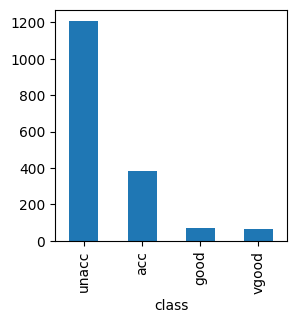

In [5]:
data['class'].value_counts().plot(kind = 'bar',figsize=(3,3))

In [6]:
data.describe()


,buyingprice,maintenancecost,doors,persons,lug_boot,safety,class
count,1727,1727,1727,1727,1727,1727,1727
unique,4,4,4,3,3,3,4
top,high,high,3,4,med,med,unacc
freq,432,432,432,576,576,576,1209


In [7]:
# data = pd.read_csv('car_evaluation.csv', names=col_names)
buying_label = {ni: n for n, ni in enumerate(set(data['buyingprice']))}
maintenancecost_label = {ni: n for n,ni in enumerate(set(data['maintenancecost']))}
doors_label = {ni: n for n, ni in enumerate(set(data['doors']))}
persons_label = {ni: n for n, ni in enumerate(set(data['persons']))}
lug_boot_label = {ni: n for n, ni in enumerate(set(data['lug_boot']))}
safety_label = {ni: n for n, ni in enumerate(set(data['safety']))}
class_label = {ni: n for n, ni in enumerate(set(data['class']))}


In [8]:
print(f"buying_label : {buying_label}")
print(f"maintenancecost_label : {maintenancecost_label}")
print(f"doors_label : {doors_label}")
print(f"persons_label : {persons_label}")
print(f"lug_boot_label : {lug_boot_label}")
print(f"safety_label : {safety_label}")
print(f"class_label : {class_label}")


buying_label : {'low': 0, 'med': 1, 'vhigh': 2, 'high': 3}
maintenancecost_label : {'low': 0, 'med': 1, 'vhigh': 2, 'high': 3}
doors_label : {'2': 0, '5more': 1, '3': 2, '4': 3}
persons_label : {'2': 0, 'more': 1, '4': 2}
lug_boot_label : {'med': 0, 'small': 1, 'big': 2}
safety_label : {'low': 0, 'med': 1, 'high': 2}
class_label : {'unacc': 0, 'acc': 1, 'vgood': 2, 'good': 3}


In [9]:
data['buyingprice'] = data['buyingprice'].map(buying_label)
data['maintenancecost'] = data['maintenancecost'].map(
    maintenancecost_label)
data['doors'] = data['doors'].map(doors_label)
data['persons'] = data['persons'].map(persons_label)
data['lug_boot'] = data['lug_boot'].map(lug_boot_label)
data['safety'] = data['safety'].map(safety_label)
data['class'] = data['class'].map(class_label)


In [10]:
class TreeNode:
    def __init__(self, depth, max_depth=None):
        self.depth = depth
        self.max_depth = max_depth
        self.feature_index = None
        self.threshold = None
        self.left = None
        self.right = None
        self.value = None  # For leaf nodes, this stores the predicted class

class DecisionTreeClassifier:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X, y):
        self.n_classes_ = len(np.unique(y))
        self.n_features_ = X.shape[1]
        self.tree_ = self._grow_tree(X, y)

    def predict(self, X):
        return [self._predict(inputs) for inputs in X]

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # Stopping conditions
        if (self.max_depth is not None and depth >= self.max_depth) or n_labels == 1 or n_samples < 2:
            leaf = TreeNode(depth)
            leaf.value = self._most_common_label(y)
            return leaf

        # Find the best split
        feature_indices = np.arange(n_features)
        candidates = np.random.choice(feature_indices, np.sqrt(n_features).astype(int), replace=False)
        best_gain = -1
        best_feature = None
        best_threshold = None
        for feature_index in candidates:
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                gain = self._information_gain(X, y, feature_index, threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_index
                    best_threshold = threshold

        if best_gain < 1e-5:  # No significant gain, create a leaf
            leaf = TreeNode(depth)
            leaf.value = self._most_common_label(y)
            return leaf

        # Split the data and build the subtrees
        left_indices = X[:, best_feature] < best_threshold
        X_left, y_left = X[left_indices], y[left_indices]
        X_right, y_right = X[~left_indices], y[~left_indices]

        left = self._grow_tree(X_left, y_left, depth + 1)
        right = self._grow_tree(X_right, y_right, depth + 1)

        node = TreeNode(depth)
        node.feature_index = best_feature
        node.threshold = best_threshold
        node.left = left
        node.right = right
        return node

    def _most_common_label(self, y):
        return np.bincount(y).argmax()

    def _information_gain(self, X, y, feature_index, threshold):
        parent_entropy = self._entropy(y)
        left_indices = X[:, feature_index] < threshold
        right_indices = ~left_indices
        n = len(y)

        if n == 0:
            return 0

        left_entropy = (len(y[left_indices]) / n) * self._entropy(y[left_indices])
        right_entropy = (len(y[right_indices]) / n) * self._entropy(y[right_indices])

        return parent_entropy - left_entropy - right_entropy

    def _entropy(self, y):
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / counts.sum()
        return -np.sum(probabilities * np.log2(probabilities + 1e-10))

    def _predict(self, inputs):
        node = self.tree_
        while node.left:
            if inputs[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.value


In [11]:
if __name__ == "__main__":
    X = data.drop(columns=['class'])
    y = data['class']
    clf = DecisionTreeClassifier(max_depth=3)
    clf.fit(X.values, y.values)  
    sample = X.values[0].reshape(1, -1)
    prediction = clf.predict(sample)
    print(f"Predicted class: {prediction}")


Predicted class: [0]


In [12]:
def k_fold_split(data, k):
    np.random.seed(42)
    data = data.sample(frac=1).reset_index(drop=True)  # Shuffle the data
    fold_size = len(data) // k
    folds = []
    for i in range(k):
        start = i * fold_size
        end = (i + 1) * fold_size if i < k - 1 else len(data)
        validation_fold = data.iloc[start:end]
        train_fold = pd.concat([data.iloc[:start], data.iloc[end:]])
        folds.append((train_fold, validation_fold))
    return folds


In [13]:
accuracy_scores = []
num_folds = 5
max_depth = 6

folds = k_fold_split(data, num_folds)
for i, (train_fold, validation_fold) in enumerate(folds):
    print(f"Fold {i + 1}:")
    X_train = train_fold.drop(columns=['class'])
    y_train = train_fold['class']
    X_val = validation_fold.drop(columns=['class'])
    y_val = validation_fold['class']

    clf = DecisionTreeClassifier(max_depth=max_depth)
    clf.fit(X_train.values, y_train.values)
    y_pred = clf.predict(X_val.values)

    accuracy = (y_pred == y_val.values).mean()
    accuracy_scores.append(accuracy)
    print(f"Accuracy: {accuracy:.2f}")

mean_accuracy = np.max(accuracy_scores)
print(f"\nMean Accuracy (5-fold cross-validation): {mean_accuracy:.2f}")


Fold 1:
Accuracy: 0.85
Fold 2:
Accuracy: 0.82
Fold 3:
Accuracy: 0.79
Fold 4:
Accuracy: 0.77
Fold 5:
Accuracy: 0.83

Mean Accuracy (5-fold cross-validation): 0.85
